In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [3]:
from pathlib import Path
from torch.nn.functional import grid_sample
from deepshape.curves import *
from scipy.ndimage import gaussian_filter1d

Two important points to decide upon:
* QMap vs SRSF
* Mean Update Rule
* Centering/No Centering

# Start with creating test data 

In [4]:
def sqnorm(x):
    return (x**2).sum(dim=-1)

def create_bump_function(amplitude, center, slope):
    return lambda x: amplitude * torch.exp(- slope**2 * sqnorm(x - center)).view(-1, 1)


def create_bump_collection(N=5, slope_rand_scale=2.):
    c = np.linspace(0.3, 0.7, N)
    a = 1. * (c - 0.5)**2 + 1. 
    slope = 10 + slope_rand_scale * np.random.randn(N)
    return [
        create_bump_function(ai, ci, si) for ai, ci, si in zip(a, c, slope)
    ]

def resample_collection(collection, k, reparametrizations=None, centering=True):
    x = col_linspace(0, 1, k)
    N = len(collection)
    if reparametrizations is None:
        X = torch.hstack([fi(x) for fi in collection]).transpose(0, 1)
    else:
        X = torch.hstack(
            [fi(ri(x)) for fi, ri in zip(collection, reparametrizations)]
        ).transpose(0, 1)
        
    if centering:
        return X - X.mean(dim=-1, keepdim=True)
    
    return X

def points_to_functional_collection(X):
    return [FuncApprox(X[i]) for i in range(X.shape[0])]

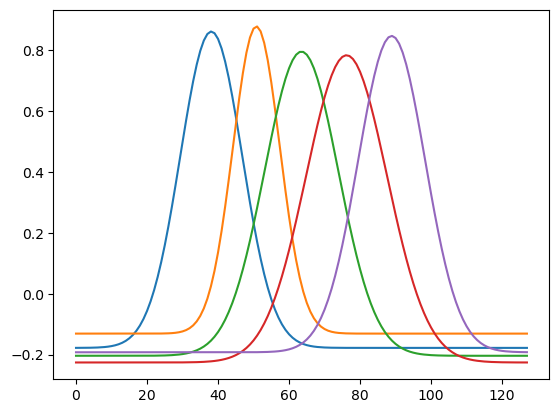

In [5]:
collection = create_bump_collection()
k = 128
X = resample_collection(collection, k, centering=True)

plt.plot(X.numpy().T)
plt.show()

In [6]:
class FuncApprox:
    def __init__(self, data):
        self.data = torch.zeros(1, 1, 1, data.shape[0])
        self.data[0, 0, 0, :] = data.squeeze()
        
    def __call__(self, x):
        grid = torch.zeros(1, 1, x.shape[0], 2)
        grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return grid_sample(self.data, grid, padding_mode='border', align_corners=False, mode='bilinear').reshape(-1, 1)
    
    def _create_grid(self, x):
        if self.grid.shape[2] != x.view(-1).shape[0]:
            self.grid = torch.zeros(1, 1, x.shape[0], 2)
        self.grid[0, 0, :, 0] = 2. * x.squeeze() - 1.
        return self.grid
    
class SRSF:
    def __init__(self, f: FuncApprox):
        self.f = f
        
    def __call__(self, x, h=1e-4):
        Df = central_differences(self.f, x, h)
        return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)


class FunctionalQmap:
    def __init__(self, f: FuncApprox):
        self.f = f
        
    def __call__(self, x, h=1e-4):
        Df = central_differences(self.f, x, h)
        return torch.sign(Df) * torch.sqrt(torch.abs(Df)+1e-8)

def linear_mean(function_collection):
    N = len(function_collection)
    def mean(x):
        return torch.hstack([fi(x) for fi in function_collection]).sum(dim=-1, keepdim=True) / N
    return mean


def torch_mse(x1, x2):
    return ((x1 - x2)**2).sum() / x1.shape[0]


def find_best_representative(q_collection):
    N = len(q_collection)
    d = np.inf * np.ones(N)
    x = col_linspace(0, 1, 512)
    m = linear_mean(q_collection)(x)
    for i, qi in enumerate(q_collection):
        d[i] = ((qi(x) - m)**2).sum()
    return np.argmin(d)

In [7]:
def find_best_representative(q_collection):
    N = len(q_collection)
    d = np.inf * np.ones(N)
    x = col_linspace(0, 1, 512)
    m = linear_mean(q_collection)(x)
    for i, qi in enumerate(q_collection):
        d[i] = ((qi(x) - m)**2).sum()
    return np.argmin(d)


def karcher_mean_step(q_collection, mu, rn_dim=(5, 5), K=1024):    
    N = len(q_collection)
    RN = [
        CurveReparametrizer([
            SineSeries(rn_dim[0]) for _ in range(rn_dim[1])
        ]) for _ in range(N)
    ]
    loss = [
        CurveDistance(mu, r, k=K, h=1e-3) for r in q_collection
    ]
    for i in range(N):
        opt = torch.optim.LBFGS(RN[i].parameters(), max_iter=100, line_search_fn='strong_wolfe')
        reparametrize(RN[i], loss[i], opt, 1, Silent())
        
        
    for rn in RN:
        for p in rn.parameters():
            p.requires_grad = False
    return RN


def amplitude_mse(mu_q, Q, k=1024):
    x = col_linspace(0, 1, k)
    return sum([((qi(x) - mu_q(x))**2).sum() for qi in Q]) / (len(Q) * k)

def karcher_mean(X0, mu0=None, K=1024, TOL=1e-4, rndim=(5, 5)):
    # Get input dimensions
    N, k = X0.shape
    
    # Create function collections
    F = points_to_functional_collection(X0)
    Q = [FunctionalQmap(fi) for fi in F]
    
    if mu0 is None:
        # Find initial mean representative
        j = find_best_representative(Q)
        mu = Q[j]
    else:
        mu = mu0
    
    e0 = np.inf
    e1 = amplitude_mse(mu, Q)
    
    # Loop until error increment is small
    print(e1)
    while e0-e1 > TOL:
        RN = karcher_mean_step(Q, mu, rndim)
        X = resample_collection(F, k, RN)
        
        # Create function collections
        F = points_to_functional_collection(X)
        Q = [FunctionalQmap(fi) for fi in F]
        
        # Compute new error
        e0 = e1
        e1 = amplitude_mse(mu, Q)
        print(e1)
        
#         mu = linear_mean(Q)
        mu = FunctionalQmap(linear_mean(F))
        
    return X

In [8]:
collection = create_bump_collection(10, 2.)
X0 = resample_collection(collection, 100)
X = karcher_mean(X0, rndim=(5, 5))
M = linear_mean(points_to_functional_collection(X))

tensor(3.0477)
tensor(0.5192)
tensor(0.4688)
tensor(0.4503)
tensor(0.4360)
tensor(0.4212)
tensor(0.4128)
tensor(0.4030)
tensor(0.3933)
tensor(0.3867)
tensor(0.3773)
tensor(0.3709)
tensor(0.3627)
tensor(0.3598)
tensor(0.3551)
tensor(0.3504)
tensor(0.3483)
tensor(0.3441)
tensor(0.3411)
tensor(0.3367)
tensor(0.3346)
tensor(0.3316)
tensor(0.3269)
tensor(0.3249)
tensor(0.3208)
tensor(0.3172)
tensor(0.3156)
tensor(0.3130)
tensor(0.3112)
tensor(0.3085)
tensor(0.3076)
tensor(0.3053)
tensor(0.3038)
tensor(0.3018)
tensor(0.3005)
tensor(0.2990)
tensor(0.2970)
tensor(0.2948)
tensor(0.2940)
tensor(0.2922)
tensor(0.2909)
tensor(0.2885)
tensor(0.2873)
tensor(0.2852)
tensor(0.2846)
tensor(0.2829)
tensor(0.2823)
tensor(0.2809)
tensor(0.2793)
tensor(0.2779)
tensor(0.2776)
tensor(0.2768)
tensor(0.2755)
tensor(0.2735)
tensor(0.2719)
tensor(0.2713)
tensor(0.2713)


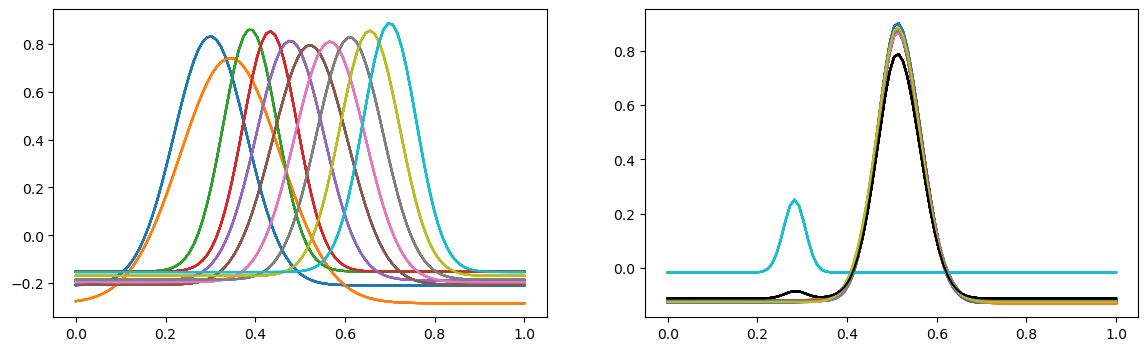

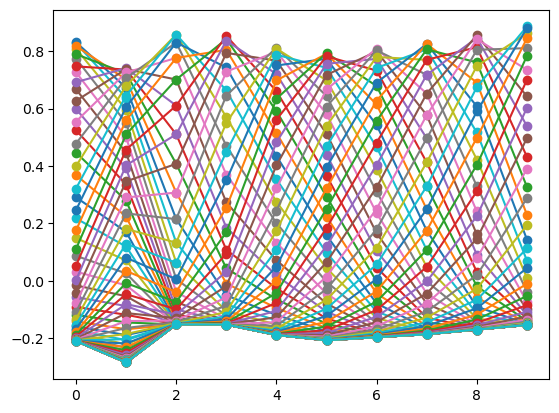

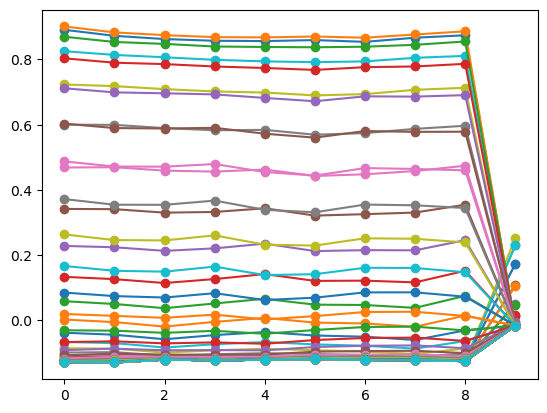

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 4))
x = col_linspace(0, 1, 512)
for i in range(len(collection)):
    ax0.plot(torch.linspace(0, 1, X0.shape[1]), X0.transpose(1, 0))

    ax1.plot(torch.linspace(0, 1, X.shape[1]), X.transpose(1, 0))
    ax1.plot(x, M(x), 'k', lw=1.5)
    
plt.show()

plt.plot(X0, 'o-')
plt.show()

plt.plot(X, 'o-')
plt.show()

# Heartbeat Data

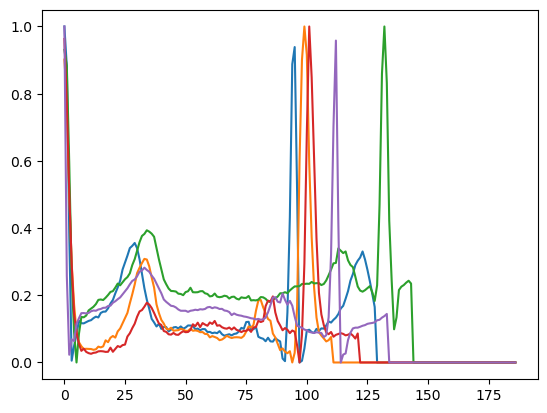

In [10]:
datapath = '../data/ptbdb_normal.csv'
dfn = pd.read_csv(datapath, header=None)
dfn, labels = dfn.iloc[:, :-1], dfn.iloc[:, -1].astype(int)
plt.plot(dfn.sample(5).transpose())
plt.show()

In [11]:
def get_ecg_curve(df, idx, sigma=1.5, remove_trailing_zeros=True):
    if type(df) is pd.DataFrame:
        df  = df.to_numpy()
        
    y = torch.tensor(df[idx], dtype=torch.float32)
    if remove_trailing_zeros:
        y = y[torch.nonzero(y, as_tuple=False)]
        
    if sigma > 0.:
        y = gaussian_filter1d(y.squeeze(), sigma=sigma)
        return torch.tensor(y).reshape(-1, 1)
    return y.reshape(-1, 1)

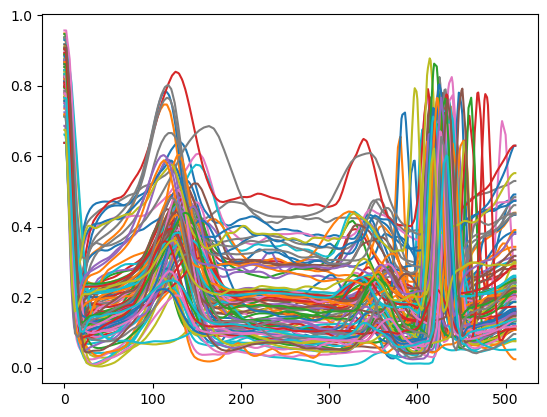

In [12]:
num_funcs = 100
X0 = resample_collection([
    FuncApprox(get_ecg_curve(dfn, i, sigma=1.2, remove_trailing_zeros=True))
    for i in torch.randint(0, high=dfn.shape[0], size=(num_funcs,))
], k=512, centering=False)

plt.plot(X0.transpose(1, 0))
plt.show()

In [13]:
X = karcher_mean(X0, rndim=(7, 7))
M0 = linear_mean(points_to_functional_collection(X0))
M = linear_mean(points_to_functional_collection(X))

tensor(2.2070)
tensor(1.3259)
tensor(0.8315)
tensor(0.7750)
tensor(0.7082)
tensor(0.7068)
tensor(0.6810)
tensor(0.6650)
tensor(0.6610)
tensor(0.6525)
tensor(0.6390)
tensor(0.6419)


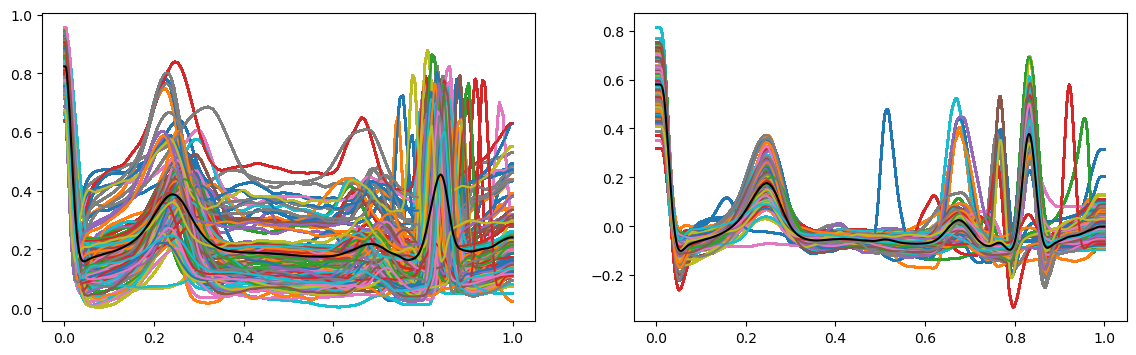

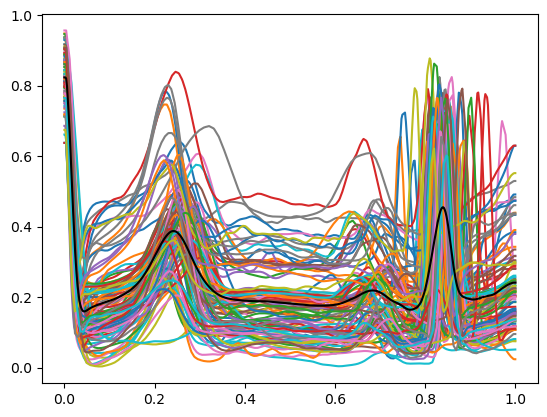

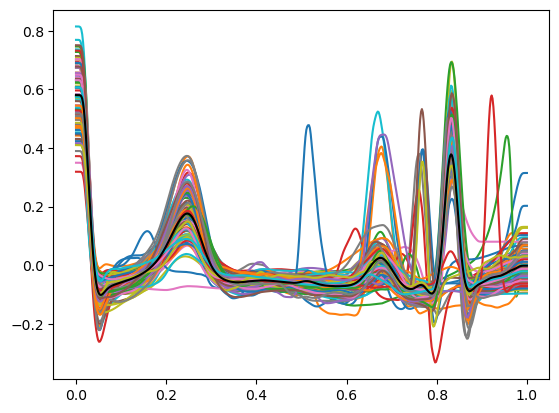

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 4))
for i in range(X0.shape[0]):
    ax0.plot(torch.linspace(0, 1, X0.shape[1]), X0.transpose(1, 0))
    ax0.plot(x, M0(x), 'k', lw=1.5)


    ax1.plot(torch.linspace(0, 1, X.shape[1]), X.transpose(1, 0))
    ax1.plot(x, M(x), 'k', lw=1.5)
    
plt.show()


plt.figure()
plt.plot(torch.linspace(0, 1, X0.shape[1]), X0.transpose(1, 0))
plt.plot(x, M0(x), 'k', lw=1.5)
plt.savefig("../figures/heartbeat-mean-before.png")
plt.show()

plt.figure()
plt.plot(torch.linspace(0, 1, X.shape[1]), X.transpose(1, 0))
plt.plot(x, M(x), 'k', lw=1.5)
plt.savefig("../figures/heartbeat-mean-after.png")
plt.show()


with open('normal-heartbeat-mean-unnormalized.npy', 'wb') as f: 
    x = col_linspace(0, 1, X.shape[1])
    np.save(f, M(x))

In [15]:
((X0 - X0.sum(dim=0) / X0.shape[0])**2).sum() / X0.shape[0]

tensor(7.7762)

In [16]:
((X - X.sum(dim=0)/ X.shape[0])**2).sum() / (X.shape[0])

tensor(1.8313)